# Chapter 16: Handling Time Series 

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
!pip install dmba

     |████████████████████████████████| 11.8MB 341kB/s 


In [2]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend


## Figure 16.1

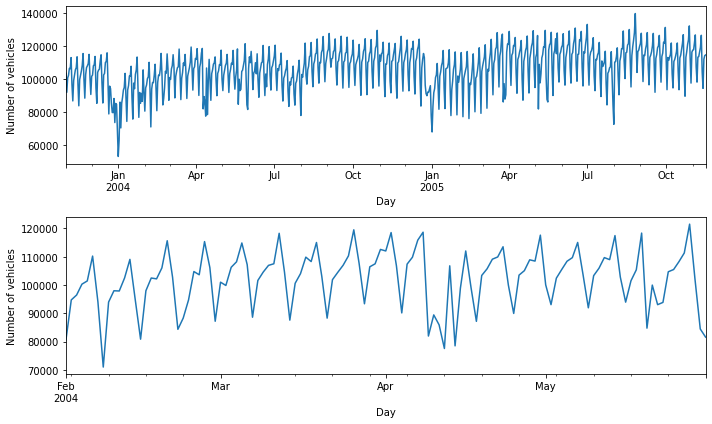

In [3]:
baregg_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/BareggTunnel.csv')

# convert the date information to a datetime object
baregg_df['Date'] = pd.to_datetime(baregg_df.Day, format='%d %b %Y')
vehicles_ts = pd.Series(baregg_df['Number of vehicles'].values, index=baregg_df.Date, name='Vehicles')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
vehicles_ts.plot(ax=axes[0])
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Number of vehicles')
vehicles_ts['2004-02-01':'2004-05-31'].plot(ax=axes[1])
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of vehicles')
plt.suptitle('')  # Suppress the overall title
plt.tight_layout()  # Increase the separation between the plots

plt.show()

In [4]:
Amtrak_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/Amtrak.csv')

# convert the date information to a datetime object
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')

# convert dataframe column to series (name is used to label the data)
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')

# define the time series frequency
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

### Figure 16.2

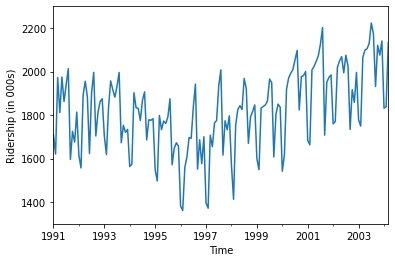

In [5]:
# plot the series
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
_ = ax.set_ylim(1300, 2300)

plt.show()

### Figure 16.3

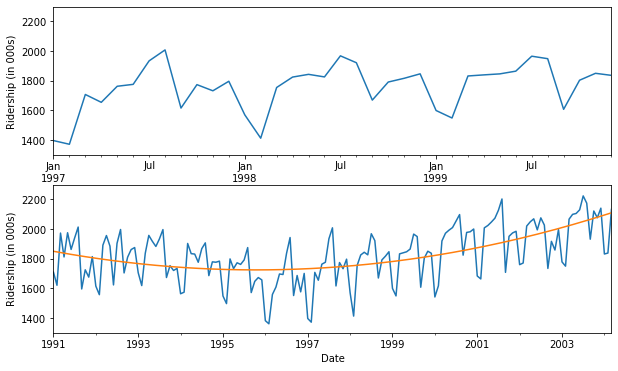

In [6]:
# create short time series from 1997 to 1999 using a slice 
ridership_ts_3yrs = ridership_ts['1997':'1999']

# create a data frame with additional independent variables from time series
# the following command adds a constant term, a trend term and a quadratic trend term
ridership_df = tsatools.add_trend(ridership_ts, trend='ctt')
# fit a linear regression model to the time series
ridership_lm = sm.ols(formula='Ridership ~ trend + trend_squared', data=ridership_df).fit()

# shorter and longer time series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
ridership_ts_3yrs.plot(ax=axes[0])
ridership_ts.plot(ax=axes[1])
for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership (in 000s)')
    ax.set_ylim(1300, 2300)
ridership_lm.predict(ridership_df).plot(ax=axes[1])
plt.show()

## Figure 16.4

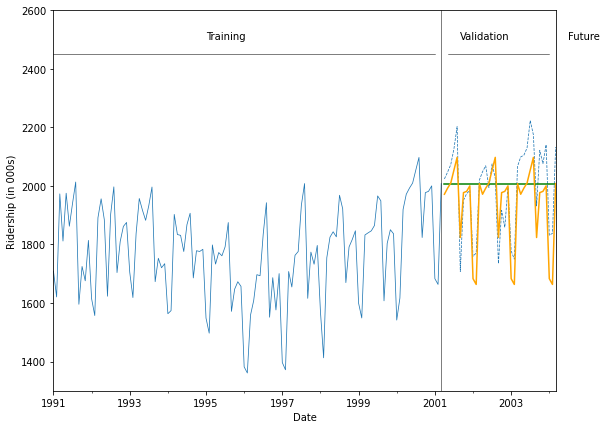

In [7]:
nValid = 36
nTrain = len(ridership_ts) - nValid

# partition the data
train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# Generate the naive and seasonal naive forecast
naive_pred = pd.Series(train_ts[-1], index=valid_ts.index)
last_season = train_ts[-12:]
seasonal_pred = pd.Series(pd.concat([last_season]*5)[:len(valid_ts)].values, index=valid_ts.index)



# plot forecasts and actual in the training and validation sets
ax = train_ts.plot(color='C0', linewidth=0.75, figsize=(9,7))
valid_ts.plot(ax=ax, color='C0', linestyle='dashed', linewidth=0.75)
ax.set_xlim('1990', '2006-6')
ax.set_ylim(1300, 2600)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')

naive_pred.plot(ax=ax, color='green')
seasonal_pred.plot(ax=ax, color='orange')


# Determine coordinates for drawing the arrows and lines
one_month = pd.Timedelta('31 days')
xtrain = (min(train_ts.index), max(train_ts.index) - one_month)
xvalid = (min(valid_ts.index) + one_month, max(valid_ts.index) - one_month)
xfuture = (max(valid_ts.index) + one_month, '2006')
xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
xvf = xvalid[1] + 0.5 * (xfuture[0] - xvalid[1])

ax.add_line(plt.Line2D(xtrain, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xvalid, (2450, 2450), color='black', linewidth=0.5))
ax.add_line(plt.Line2D(xfuture, (2450, 2450), color='black', linewidth=0.5))
ax.text('1995', 2500, 'Training')
ax.text('2001-9', 2500, 'Validation')
ax.text('2004-7', 2500, 'Future')
ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
ax.axvline(x=xvf, ymin=0, ymax=1, color='black', linewidth=0.5)
plt.show()

### Table 16.1

In [8]:
regressionSummary(valid_ts, naive_pred)


Regression statistics

                      Mean Error (ME) : -14.7177
       Root Mean Squared Error (RMSE) : 142.7551
            Mean Absolute Error (MAE) : 115.9234
          Mean Percentage Error (MPE) : -1.2750
Mean Absolute Percentage Error (MAPE) : 6.0214


In [9]:
regressionSummary(valid_ts, seasonal_pred)


Regression statistics

                      Mean Error (ME) : 54.7296
       Root Mean Squared Error (RMSE) : 95.6243
            Mean Absolute Error (MAE) : 84.0941
          Mean Percentage Error (MPE) : 2.6528
Mean Absolute Percentage Error (MAPE) : 4.2477


In [10]:
print('naive model in training set')
regressionSummary(train_ts[1:], train_ts[:-1])

print('seasonal model in training set')
regressionSummary(train_ts[12:], train_ts[:-12])

naive model in training set

Regression statistics

                      Mean Error (ME) : 2.4509
       Root Mean Squared Error (RMSE) : 168.1470
            Mean Absolute Error (MAE) : 125.2975
          Mean Percentage Error (MPE) : -0.3460
Mean Absolute Percentage Error (MAPE) : 7.2714
seasonal model in training set

Regression statistics

                      Mean Error (ME) : 13.9399
       Root Mean Squared Error (RMSE) : 99.2656
            Mean Absolute Error (MAE) : 82.4920
          Mean Percentage Error (MPE) : 0.5851
Mean Absolute Percentage Error (MAPE) : 4.7153


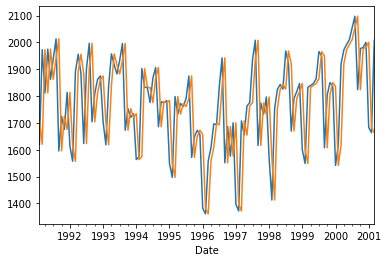

In [11]:
naive_train_ts = pd.Series(train_ts[:-1].values, index=train_ts[1:].index)
ax = train_ts[1:].plot()
naive_train_ts.plot(ax=ax)

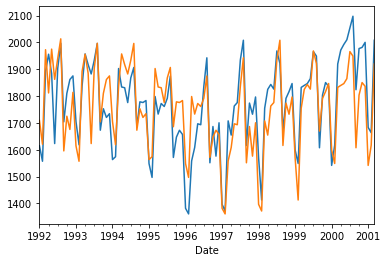

In [12]:
seasonal_train_ts = pd.Series(train_ts[:-12].values, index=train_ts[12:].index)
ax = train_ts[12:].plot()
seasonal_train_ts.plot(ax=ax)

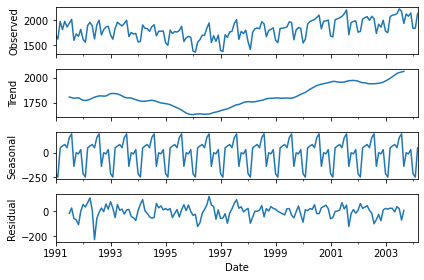

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ridership_ts, model='additive')
result.plot()
plt.show()